In [14]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
cov = pm.gp.cov
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

sns.set_context("notebook")

In [15]:
# Time series of recorded coal mining disasters in the UK from 1851 to 1962
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                        3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                        2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                        1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                        0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                        3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
year = np.arange(1851, 1962)
year_ind = (year-year.min()).reshape(-1,1)

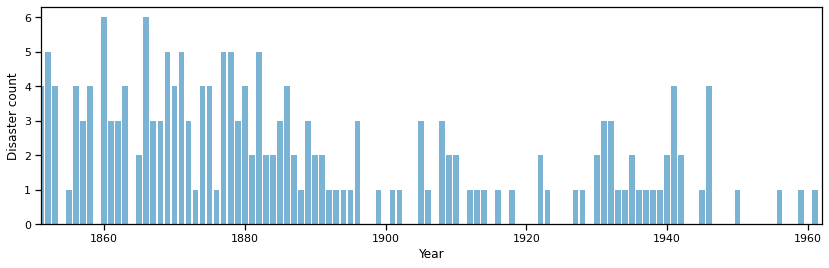

In [16]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(year, disasters_data, color="#348ABD", alpha=0.65, width=0.8)
ax.set_xlim(year[0], year[-1]+1)
ax.set_ylabel('Disaster count')
ax.set_xlabel('Year');

In [17]:
with pm.Model() as disasters_model:
    
    rho = pm.Exponential('ρ', 1)
    nu = pm.Exponential('η', 1)
    
    K = nu * nu * cov.ExpQuad(1, rho)
    gp = pm.gp.Latent(cov_func=K)

    f = gp.prior('f', X=year_ind)

    lamb = pm.Deterministic('λ', pm.math.exp(f))
    
    confirmation = pm.Poisson('confirmation', lamb, observed=disasters_data)

    trace = pm.sample(1000, tune=1000, chains=4)
    y_pred = pm.sample_posterior_predictive(trace, vars=[f], samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


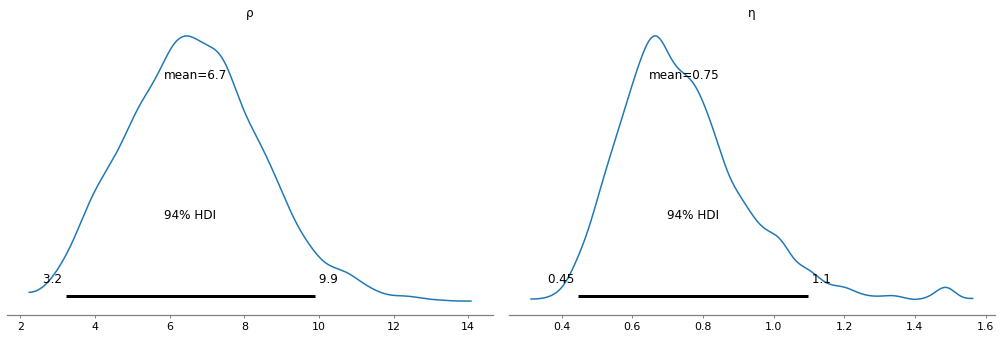

In [18]:
az.plot_posterior(trace, var_names=['ρ', 'η']);

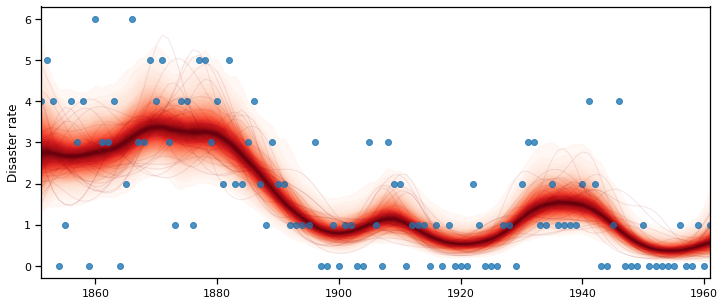

In [19]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, np.exp(y_pred["f"]), year[:, None])
sns.regplot(year, disasters_data, fit_reg=False, ax=ax)
ax.set_xlim(year.min(), year.max())
ax.set_ylabel('Disaster rate');